##  주제 :  여행 상품 계약률을 높이기 위한 방안 도출



#### 1.  데이터 준비   
1-1    데이터 컬럼 확인   
1-2    데이터 전처리   

#### 2.       고객 분석 및 비지니스 과제 도출  
2-1    고객분석    
2-2    비지니스 과제 도출    
2-3    계약률이 높은 10~20대 고객 분석 및 신규 고객 확보 방안   
2-4    계약률이 낮은 30대 후반 고객 분석 및 인사이트 제안   

#### 3.   영업 데이터 분석 및 비지니스 과제 도출   
3-1    영업 관련 데이터 분석    
3-2    비지니스 과제 도출    
3-3    영업 시 활용 가능한 수요 예측 모델 개발   



#### 1.  데이터 준비


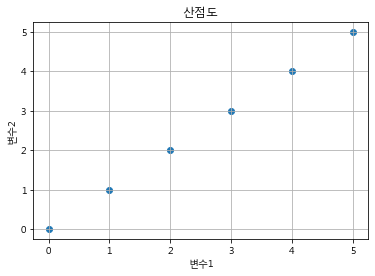

In [55]:
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt

%matplotlib inline
font_path = "/users/eunji/library/fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
 
plt.scatter([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5])
plt.title('산점도')
plt.xlabel('변수1')
plt.ylabel('변수2')
plt.grid(True)
plt.show()

In [56]:
import seaborn as sns
import matplotlib as mpl
from scipy.stats import chi2_contingency
import matplotlib.gridspec as gridspec

In [57]:
import pandas as pd
import numpy as np
from pandas import Series
import warnings                                                                     # 경고 메시지를 무시하고 숨기기 
warnings.filterwarnings('ignore')                                                   # import warnings  # warnings.filterwarnings('ignore') 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
from sklearn.metrics import accuracy_score   

In [58]:
train = pd.read_csv('/Users/EUNJI/Desktop/dacon/여행상품신청여부예측/tour_package.csv')


#### 1-1 데이터 컬럼 확인

In [59]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CustomerID                4888 non-null   int64  
 1   ProdTaken                 4888 non-null   int64  
 2   Age                       4662 non-null   float64
 3   TypeofContact             4863 non-null   object 
 4   CityTier                  4888 non-null   int64  
 5   DurationOfPitch           4637 non-null   float64
 6   Occupation                4888 non-null   object 
 7   Gender                    4888 non-null   object 
 8   NumberOfPersonVisiting    4888 non-null   int64  
 9   NumberOfFollowups         4843 non-null   float64
 10  ProductPitched            4888 non-null   object 
 11  PreferredPropertyStar     4862 non-null   float64
 12  MaritalStatus             4888 non-null   object 
 13  NumberOfTrips             4748 non-null   float64
 14  Passport

In [ ]:
# 데이터는 여행업체의 고객 정보 및 영업 관련 데이터
# 고객의 신청 여부 컬럼은 있으나, 최종 선택 상품에 대한 데이터가 없기 때문에, 
# 겨약자는 영업사원에게 추천 받은 상품으로 최종 계약했다고 가정하고 분석을 진행했습니다. 



# 개인 정보 
CustomerID : 고객 아이디
Age : 나이
Gender : 성별
Occupation : 직업
Designation : (직업의) 직급
MonthlyIncome : 월 급여                          
OwnCar : 자동차 보유 여부 (0: 없음, 1: 있음)
CityTier : 주거 중인 도시의 등급. (인구, 시설, 생활 수준 기준) (1등급 > 2등급 > 3등급)
MaritalStatus : 결혼 여부
    
    
# 여행 관련 개인 정보 
Passport : 여권 보유 여부 (0: 없음, 1: 있음)
NumberOfTrips : 평균 연간 여행 횟수 
NumberOfChildrenVisiting : 고객과 함께 여행을 계획 중인 5세 미만의 어린이 수     
NumberOfPersonVisiting : 고객과 함께 여행을 계획 중인 총 인원
PreferredPropertyStar : 선호 호텔 숙박업소 등급  (1~5star)

    
# 여행 마케팅, 고객 영업 관련 정보  
TypeofContact : 고객의 제품 인지 방법 (회사의 홍보 or 스스로 검색)
ProductPitched : 영업 사원이 제시한 상품  (여행 상품 : Basic, Standard, Deluxe, Super, Deluxe, King)
PitchSatisfactionScore : 영업 사원의 프레젠테이션 만족도
DurationOfPitch : 영업 사원이 고객에게 제공하는 프레젠테이션 기간
NumberOfFollowups : 영업 사원의 프레젠테이션 후 이루어진 후속 조치 수

# y 목표값   
ProdTaken : 여행 패키지 신청 여부 (0: 신청 안 함, 1: 신청함)
    

####  * 기본 가정 : 계약 고객은 영업사원에게 추천 받은 상품(Product Pitched)으로 최종 계약했다고 가정
          (주어진 데이터에 고객의 최종 계약 상품에 대한 데이터가 없기 때문에 
          심도있는 분석을 위해 위와 같이 가정하고 분석을 진행)
#### 

In [61]:
# 불필요한 CustomerID 칼럼 제거
train = train.drop(['CustomerID'],axis=1)

# 정확한 분석을 위해 데이터가 누락된 행은 drop
train = train.dropna()

In [62]:
# train data 피처요약표 함수 : 피처요약표로 데이터들의 대략적인 정보를 얻기 

def resumetable(df):
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index':'피처'})
    summary['결측값 개수'] = df.isnull().sum().values
    summary['고윳값 개수'] = df.nunique().values
    summary['첫번째 값'] = df.loc[0].values
    summary['두번째 값'] = df.loc[1].values
    summary['세번째 값'] = df.loc[2].values
    summary = summary.sort_values('데이터 타입').reset_index(drop=True)

    return summary

resumetable(train)

,피처,데이터 타입,결측값 개수,고윳값 개수,첫번째 값,두번째 값,세번째 값
0,ProdTaken,int64,0,2,1,0,1
1,OwnCar,int64,0,2,1,1,0
2,CityTier,int64,0,3,3,1,1
3,PitchSatisfactionScore,int64,0,5,2,3,3
4,Passport,int64,0,2,1,0,1
5,NumberOfPersonVisiting,int64,0,5,3,3,3
6,NumberOfChildrenVisiting,float64,0,4,0.0,2.0,0.0
7,NumberOfTrips,float64,0,12,1.0,2.0,7.0
8,PreferredPropertyStar,float64,0,3,3.0,4.0,3.0
9,MonthlyIncome,float64,0,2182,20993.0,20130.0,17090.0


#### 1-2 데이터 전처리

In [63]:
# Product Pitched (영업사원이 고객에게 추천한 상품) -> 등급별로 라벨링 

# 'Basic':1, 'Standard':2, 'Deluxe':3, 'Super Deluxe':4, 'King':5

dic = {'Basic':1, 'Standard':2, 'Deluxe':3, 'Super Deluxe':4, 'King':5 }
train['ProductPitched_le'] = train['ProductPitched'].replace(dic)

AxesSubplot(0.125,0.125;0.775x0.755)
이상치 1개 삭제 완료


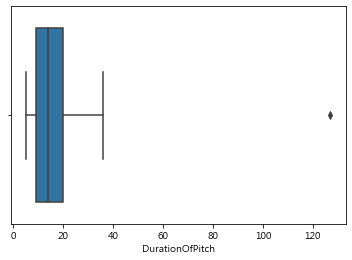

In [64]:
# DurationOfPitch (영업사원이 고객에게 추천한 기간) -> max값은 이상치로 분류해 삭제 


print(sns.boxplot(train['DurationOfPitch'])) 
train = train[train['DurationOfPitch'] != train['DurationOfPitch'].max()]
print('이상치 1개 삭제 완료')

In [65]:
# 'DurationOfPitch (영업사원이 고객에게 추천한 기간)  ->  단위 변경 (일 => 1주일 단위로)

# 1주 미만          -> 0
# 1주 이상 2주 미만   -> 1 
# 2주 이상 3주 미만   -> 2
# 3주 이상 4주 미만   -> 3
# 4주 이상 5주 미만   -> 4
# 5주 이상          -> 5


train['DurationOfPitch(주별)'] = train['DurationOfPitch']//7
train['DurationOfPitch(주별)'].unique() 

# unique value = [ 0.,  2.,  1.,  4.,  3.,  5., 18.]


li=[]
for i in train['DurationOfPitch(주별)'] : 
    if i  <= 5:
        li.append(i)
    else : 
        li.append(5)
train['DurationOfPitch(주별)'] = li

In [66]:
train.columns

Index(['ProdTaken', 'Age', 'TypeofContact', 'CityTier', 'DurationOfPitch',
       'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'MaritalStatus',
       'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'OwnCar',
       'NumberOfChildrenVisiting', 'Designation', 'MonthlyIncome',
       'ProductPitched_le', 'DurationOfPitch(주별)'],
      dtype='object')

AxesSubplot(0.125,0.125;0.775x0.755)


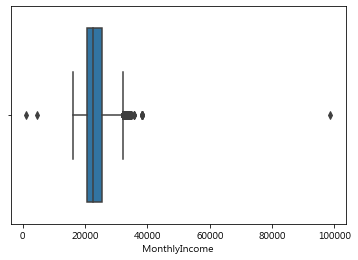

In [67]:
# MonthlyIncome 고객의 월 소득 -> 이상치 삭제 ($10000이하, $40000이상)

print(sns.boxplot(train['MonthlyIncome']))
train = train[(train['MonthlyIncome']<=40000)|(train['MonthlyIncome']>=10000)]

In [68]:
# MonthlyIncome 고객의 월 소득 -> binning

# 20000미만            -> 0
# 20000이상 22500미만   -> 1
# 22500이상 25000미만   -> 2
# 25000이상 27500미만   -> 3
# 27500이상 29000미만   -> 4
# 290000이상           -> 5

train = train.dropna() 

li=[]
a=0
for i in train['MonthlyIncome']:
    if  i < 20000 :
        a=0
        li.append(a)
    elif i < 22500: 
        a=1
        li.append(a)
    elif i< 25000:
        a=2
        li.append(a)
    elif i< 27500:
        a=3
        li.append(a)
    elif i< 29000:
        a=4
        li.append(a)
    else :
        a=5
        li.append(a)
        
train['MonthlyIncome_le'] = li

In [69]:
# Number Of Children Visiting 컬럼을 활용해, 파생변수 생성 ->  어린이 동반 / 미동반으로 분류한 Children Visiting 변수 추기 

# 동반 : 1, 미동반 :0 
d = {0:0, 1:1, 2:1, 3:1}
train['ChildrenVisiting'] = train['NumberOfChildrenVisiting'].replace(d)
print(train['ChildrenVisiting'].value_counts())

1.0    3278
0.0     849
Name: ChildrenVisiting, dtype: int64


In [70]:
# 고유값 확인을 통해 성별 Fe Male을 Female로 변경해야함을 확인 
for col in train.columns:
    print(f'{col}: {train[col].unique()}')

ProdTaken: [1 0]
Age: [41. 49. 37. 33. 32. 59. 30. 38. 36. 35. 31. 34. 28. 29. 22. 53. 21. 42.
 44. 46. 39. 24. 43. 50. 27. 26. 48. 55. 45. 56. 23. 51. 40. 54. 58. 20.
 25. 19. 57. 52. 47. 18. 60. 61.]
TypeofContact: ['Self Enquiry' 'Company Invited']
CityTier: [3 1 2]
DurationOfPitch: [ 6. 14.  8.  9. 30. 29. 33. 22. 32. 25. 27. 11. 13. 21. 12. 16. 15. 10.
 31. 18. 17. 24. 35. 28. 26. 34. 20. 23.  5. 19.  7. 36.]
Occupation: ['Salaried' 'Free Lancer' 'Small Business' 'Large Business']
Gender: ['Female' 'Male' 'Fe Male']
NumberOfPersonVisiting: [3 2 1 4 5]
NumberOfFollowups: [3. 4. 2. 5. 1. 6.]
ProductPitched: ['Deluxe' 'Basic' 'Standard' 'Super Deluxe' 'King']
PreferredPropertyStar: [3. 4. 5.]
MaritalStatus: ['Single' 'Divorced' 'Married' 'Unmarried']
NumberOfTrips: [ 1.  2.  7.  5.  6.  3.  4. 19. 21.  8. 20. 22.]
Passport: [1 0]
PitchSatisfactionScore: [2 3 5 4 1]
OwnCar: [1 0]
NumberOfChildrenVisiting: [0. 2. 1. 3.]
Designation: ['Manager' 'Executive' 'Senior Manager' 'AVP' 'VP']
M

In [71]:
# Gender 성별  ->'Fe Male'을 'Female'로 변경
train['Gender'] = train['Gender'].str.replace('Fe Male','Female')
train['Gender'].value_counts()

Male      2462
Female    1665
Name: Gender, dtype: int64

In [72]:
# Age 컬럼 -> 범주화 
#  '15~19세' : 0 ,'20~24세' : 1, '25~29세' : 2,'30~34세' : 3,'35세~39세' : 4
#  '40~44세' : 5, '45~49세' : 6, '50~54세' : 7, '55세 이상': 8
train['Age_category'] = train['Age']// 5 - 3
train['Age_category'].value_counts()
li=[]
for i in train['Age_category']:
    if i>=8 :
        li.append(8)
    else :
        li.append(i)
train['Age_category'] = li

In [73]:
# NumberOfTrips 평균 연간 여행 횟수 -> 범주화

# 0~2회   : 0
# 3~5회   : 1
# 6회 이상 : 2

li=[]
for i in train['NumberOfTrips']//3: 
    if i < 2:
        li.append(i)
    else :
        li.append(2)
train['NumberOfTrips_le'] = li
train['NumberOfTrips_le'].value_counts()

1.0    1810
0.0    1734
2.0     583
Name: NumberOfTrips_le, dtype: int64

In [74]:
print(train['Occupation'].value_counts())#  프리렌서의 수가 너무 적기 때문에 프리렌서를 small bisiness로 간주 
train['Occupation'] = train['Occupation'].replace({'Free Lancer':'Small Business'})

Salaried          1998
Small Business    1746
Large Business     381
Free Lancer          2
Name: Occupation, dtype: int64


In [75]:
# Type of Contact 고객의 제품 인지 방법 -> 라벨인코딩 
# 회사 홍보 1, 직접 검색 0
dic = {'Company Invited':1,'Self Enquiry':0 }
train['TypeofContact_le'] =  train['TypeofContact'].replace(dic)
train['TypeofContact_le'].unique()

array([0, 1])

In [76]:
# Designation 직급 -> 직급별로 라벨인코딩
dic={'Manager' : 1, 'Senior Manager':2, 'AVP':3 ,'VP':4, 'Executive':5}
train['Designation_le']=train['Designation'].replace(dic)

In [77]:
# ProdTaken 여행 패키지 신청 여부 -> 계약 여부 변수와 다른 변수들간의 카이제곱분석 진행

features = train.columns
li1=[]
li2=[]
for i in features:
    chi2, p, dof, expected_ = chi2_contingency(pd.crosstab(train['ProdTaken'],train[i]))
    p = round(p,3)
    li1.append(chi2)
    li2.append(round(p,3))
    

pd.DataFrame(li2, index = train.columns,columns=['p값'] ).sort_values('p값', ascending=False)

# 카이제곱 분석에서 p-value값이 0.05이상이면 여행 패키지 신청 여부에 영향을 준다고 보기 어렵기 때문에 변수 drop

# NumberOfChildrenVisiting, ChildrenVisiting => 어린이 동반 여부와 동반 어린이수는 고객의 여행상품 신청에 영향을 준다고 보기 어려움

# Gender, OwnCar  -> 성별, 차량 소유, 여행객수는 여행상품 상품 신청에 영향을 준다고 보기 어려움


,p값
NumberOfChildrenVisiting,0.958
ChildrenVisiting,0.736
OwnCar,0.609
NumberOfPersonVisiting,0.107
Gender,0.076
PitchSatisfactionScore,0.001
ProdTaken,0.000
TypeofContact_le,0.000
NumberOfTrips_le,0.000
Age_category,0.000


In [78]:
# 해당 컬럼 삭제
train = train.drop(['NumberOfChildrenVisiting', 'ChildrenVisiting', 'Gender', 'OwnCar' ], 1)

#### 2. 고객분석 및 비지니스 과제 도출
#### 2-1 고객분석

In [79]:
# 고객 관련 변수들로, 계약률이 어떻게 달라지는지 확인해본다. 

cols = ['NumberOfTrips_le', 'Age_category', 'CityTier', 'Passport', 
        'Occupation', 'Designation_le', 'MonthlyIncome_le', 'MaritalStatus']

li=[]

for x in cols :
    chi2, p, dof, expected_ = chi2_contingency( pd.crosstab(train[x],train['ProdTaken']))
    if p > 0.05:
        li.append(x)
    else :
        실제 = pd.crosstab(train[x],train['ProdTaken']).rename(columns = {0:'실제_0',1:'실제_1'})
        예상 = pd.DataFrame(expected_,columns=['예상_0','예상_1'])
        pd.concat([예상,실제], 1)
        expected_rate = round((예상['예상_1']/예상.sum(axis=1)).values[0]*100,1)
        print()
        #print(f'{x}  평균 계약률 (%) : {expected_rate}')
        #print('실제 계약률(%)')
        print(round(실제['실제_1']/실제.sum(axis=1)*100,1))
        print(round(p,10))
print(f'pass : {li}')   



#  여권 소유 여부, 나이, 결혼 여부 
#  따라서 나이, 결혼 여부 등의 정보로 타게팅을 하는 것이 필요하다고 보았다. 



NumberOfTrips_le
0.0    20.6
1.0    16.6
2.0    23.8
dtype: float64
0.0001332076

Age_category
0.0    69.0
1.0    42.1
2.0    28.0
3.0    20.9
4.0    11.3
5.0    15.8
6.0    13.6
7.0    14.8
8.0    17.1
dtype: float64
0.0

CityTier
1    16.5
2    26.5
3    24.2
dtype: float64
5.4e-09

Passport
0    12.4
1    35.8
dtype: float64
0.0

Occupation
Large Business    29.1
Salaried          18.0
Small Business    18.7
dtype: float64
1.9319e-06

Designation_le
1    11.6
2    16.1
3     7.6
4     8.7
5    30.0
dtype: float64
0.0

MonthlyIncome_le
0    28.9
1    21.9
2    14.8
3    14.6
4    17.7
5    10.5
dtype: float64
0.0

MaritalStatus
Divorced     13.3
Married      14.2
Single       36.4
Unmarried    24.3
dtype: float64
0.0
pass : []


Text(0.5, 1.0, '미계약/계약고객')

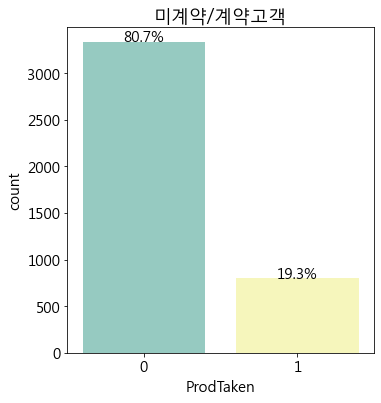

In [142]:
# 계약고객/ 미계약고객 비율          
def write_percent(ax, total_size):
    
  # 막대 그래프 상단에 타깃값 비율 표시
  for patch in ax.patches:
    height = patch.get_height() # 도형 높이(데이터 개수)
    width = patch.get_width()   # 도형 너비
    left_coord = patch.get_x()  # 도형 왼쪽 테두리의 x축 위치
    percent = height/total_size*100 # 타깃값 비율

    # (x,y) 좌표에 텍스트 입력
    ax.text(left_coord + width/2.0,
            height + total_size*0.001,
            '{:1.1f}%'.format(percent),
            ha='center')


plt.rc('font', size=15)
plt.figure(figsize=(5.5,6))

ax = sns.countplot(x='ProdTaken', data=train, palette='Set3')
write_percent(ax, len(train))
ax.set_title('미계약/계약고객')

* 전체 고객 중, 
* 계약 고객 (평균 계약률): 19.3% 
* 미계약 고객 : 80.7%

##### 

Age_category_2,10대,20~24세,25~29세,30~34세,35~39세,40~44세,45~49세,50~54세,55세이상
계약률(%),69.0,42.1,28.0,20.9,11.3,15.8,13.6,14.8,17.1


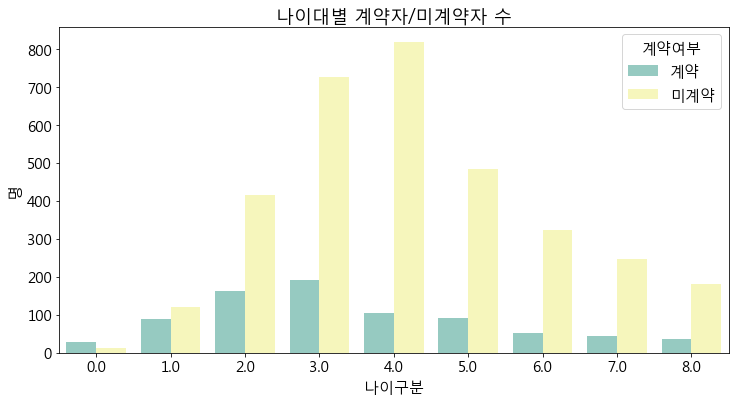

In [143]:
# 나이대별 계약자/미계약자 수
train['계약여부'] = train['ProdTaken'].replace({0:'미계약',1:'계약'})
plt.figure(figsize=(12,6))
ax = sns.countplot(x='Age_category', data=train, hue='계약여부', palette='Set3')
plt.ylabel('명')
plt.xlabel('나이구분')
plt.title('나이대별 계약자/미계약자 수')

# 나이대별 계약률(구매전환율)

dic={0:'10대',1:'20~24세', 2:'25~29세', 3:'30~34세', 4:'35~39세', 5:'40~44세', 6:'45~49세', 7:'50~54세', 8:'55세이상' }
train['Age_category_2'] = train['Age_category'].replace(dic)

df_age_prod = pd.crosstab(train['Age_category_2'],train['ProdTaken'])
구매전환율 = df_age_prod.apply(lambda x : round(x/df_age_prod.sum(axis=1),3)*100)[1]
df_age_계약률 = pd.DataFrame(구매전환율).rename(columns={1:'계약률(%)'})
df_age_계약률.T


* 계약률 max : 69.0% (15-19세)
* 계약률 min : 11.3% (35-39세)

#### * 높은 계약률을 보인 그룹 

   15-19세 (69.0%)       
   20-24세 (42.1%)     
   25-29세 (28.0%)

#### * 계약률이 평균과 비슷한 그룹 

   30-34세 (20.9%)
 
#### * 계약률이 평균 이하인 그룹 

   35-39세 (11.3%)   
   40-44세 (15.8%)   
   45-49세 (13.6%)    
   55세이상 (17.1%)


In [144]:
# [ 나이대별 고객 비율(%) ]

방문고객 = train['Age_category'].value_counts().sort_index()
계약고객= train.loc[train['ProdTaken']==1, 'Age_category'].value_counts().sort_index()
방문고객비율 = round(train['Age_category'].value_counts(normalize=True),3).sort_index()*100
계약고객비율= train.loc[train['ProdTaken']==1, 'Age_category'].value_counts(normalize=True).sort_index().map(lambda x : round(x,3)*100)

df = pd.concat([방문고객,  계약고객, 방문고객비율, 계약고객비율],1)
df.columns=['방문고객(명)','계약고객(명)' ,'방문고객비율(%)','계약고객비율(%)']
df.index = ['10대','20~24세','25~29세','30~34세','35세~39세', '40~44세','45~49세', '50~54세','55세이상']
df.loc['전체']=round(df.sum())

In [145]:
def write_percent_2(ax, total_size):
    
  # 막대 그래프 상단에 타깃값 비율 표시
  for patch in ax.patches:
    height = patch.get_height() # 도형 높이(데이터 개수)
    width = patch.get_width()   # 도형 너비
    left_coord = patch.get_x()  # 도형 왼쪽 테두리의 x축 위치
    percent = height/total_size # 타깃값 비율

    # (x,y) 좌표에 텍스트 입력
    ax.text(left_coord + width/2.0,
            height + total_size*0.001,
            '{:1.1f}%'.format(percent),
            ha='center')

Text(0.5, 1.0, '나이대별 계약률')

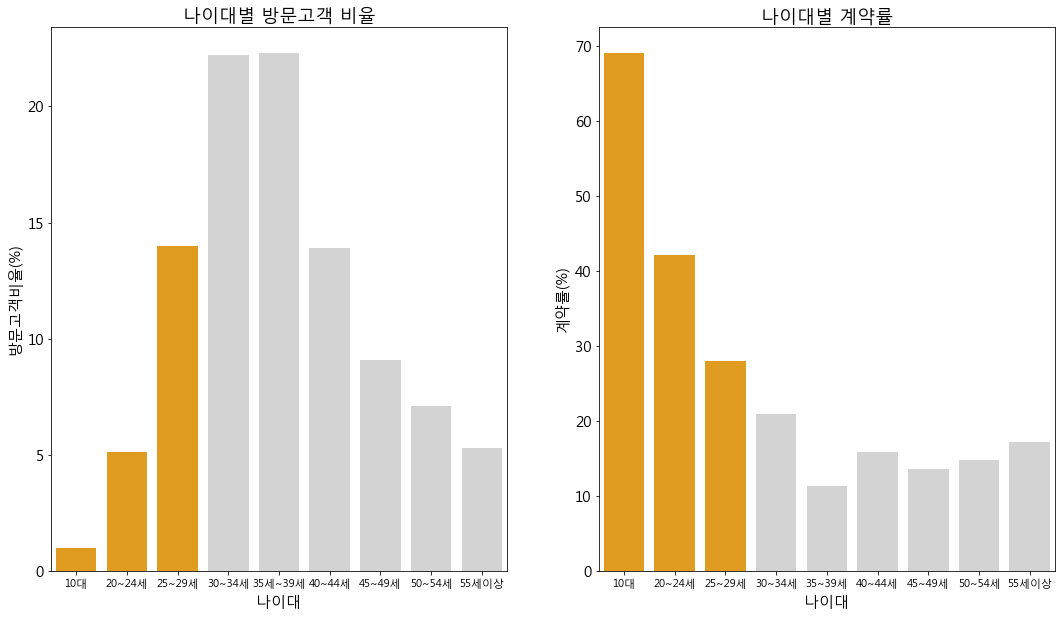

In [146]:
plt.figure(figsize=(18,10))


palette = ['orange' ,'orange','orange','lightgrey','lightgrey','lightgrey','lightgrey','lightgrey','lightgrey']
df_방문고객비중 = df.drop(['전체'],0).reset_index().rename(columns={'index':'나이대'})
area1= plt.subplot(1,2,1)
ax2 = sns.barplot(data= df_방문고객비중, x='나이대', y='방문고객비율(%)', palette=palette, ax=area1)
plt.xticks(fontsize=11)
plt.title('나이대별 방문고객 비율')

area2= plt.subplot(1,2,2)
values = df_age_계약률['계약률(%)']
idx = df_age_계약률.index
ax1 = sns.barplot( x= idx, y=values, palette=palette, ax=area2)
plt.xlabel('나이대')
plt.xticks(fontsize=11)
plt.title('나이대별 계약률')

Text(0.5, 1.0, '나이대별 계약률')

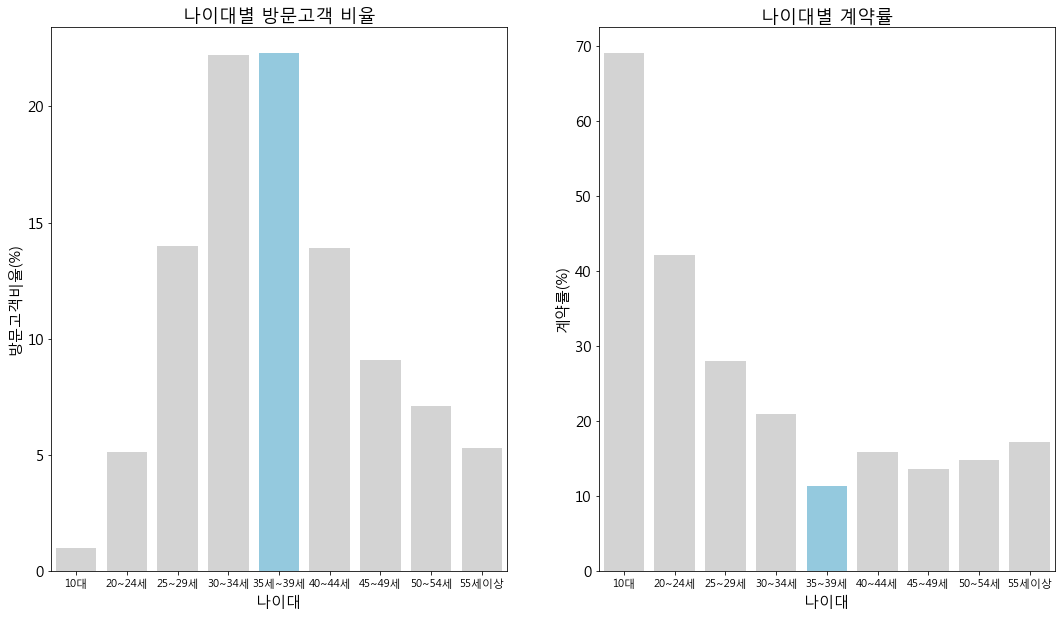

In [147]:
plt.figure(figsize=(18,10))


palette = ['skyblue' if (x == min(values)) else 'lightgrey' for x in values]
df_방문고객비중 = df.drop(['전체'],0).reset_index().rename(columns={'index':'나이대'})
area1= plt.subplot(1,2,1)
ax2 = sns.barplot(data= df_방문고객비중, x='나이대', y='방문고객비율(%)', palette=palette, ax=area1)
plt.xticks(fontsize=11)
plt.title('나이대별 방문고객 비율')

area2= plt.subplot(1,2,2)
values = df_age_계약률['계약률(%)']
idx = df_age_계약률.index
ax1 = sns.barplot( x= idx, y=values, palette=palette, ax=area2)
plt.xlabel('나이대')
plt.xticks(fontsize=11)
plt.title('나이대별 계약률')





####  2-2 비지니스 과제 도출


####  1. 높은 계약률을 보이는 10~20대 신규 고객 확보 방안 마련 필요
* 10-20대는 매우 높은 구매전환율을 보이지만, 전체방문고객 중 20%밖에 되지 않는다.




#### 2. 계약률이 낮은 30대 후반 고객층의 계약률을 높이기 위한 방안 마련 필요
* 35~39세 고객들은 전체 방문 고객의 22.3%를 차지하는 주요 고객층이지만, 계약율은 11.3%로 전 연령대 중 가장 낮은 수치를 보인다.


#### 2-3.           높은 계약률을 보이는 10~20대 신규 고객 확보 방안 

[나이대별 여행 상품 선호]


ProductPitched,Basic,Deluxe,King,Standard,Super Deluxe,합계
10대,96.6,0.0,0.0,3.4,0.0,100.0
20~24세,94.3,4.5,0.0,1.1,0.0,100.0
25~29세,79.6,12.3,1.2,6.8,0.0,100.0
30~34세,62.0,24.0,0.0,14.1,0.0,100.0
35세~39세,40.4,35.6,0.0,22.1,1.9,100.0
40~44세,50.5,23.1,4.4,8.8,13.2,100.0
45~49세,21.6,27.5,2.0,43.1,5.9,100.0
50~54세,23.3,39.5,0.0,37.2,0.0,100.0
55세이상,45.9,16.2,5.4,27.0,5.4,100.0


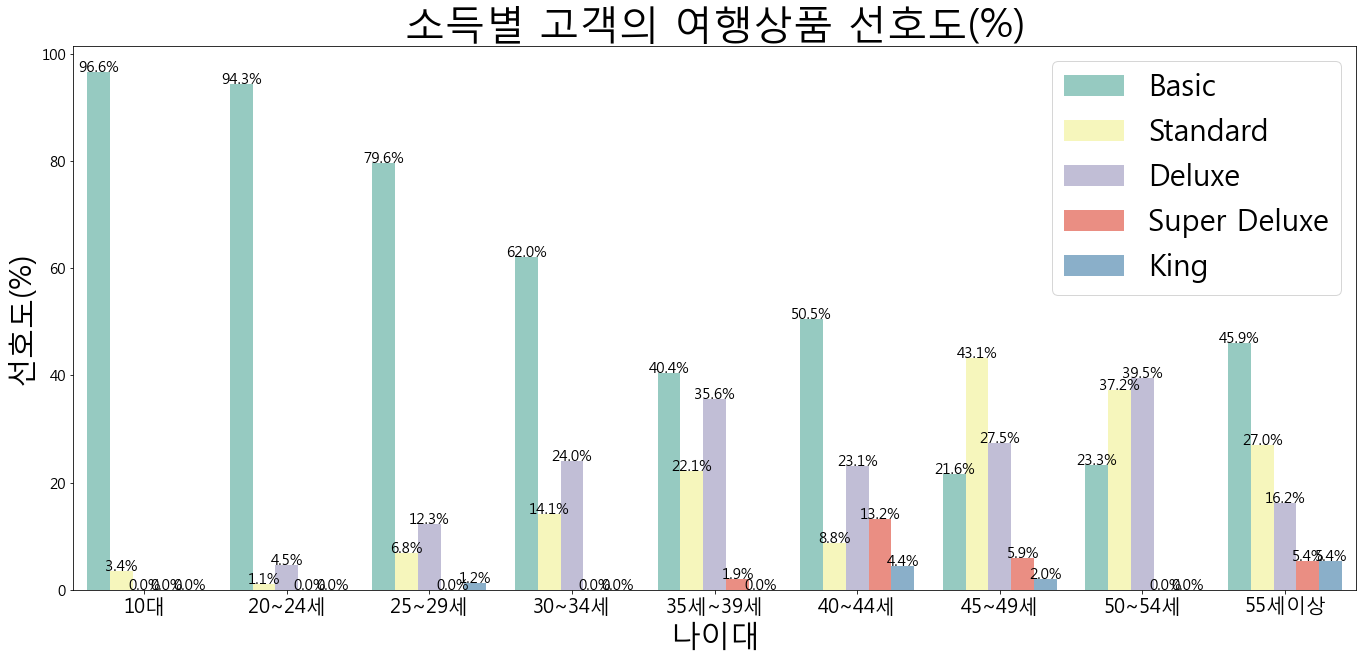

In [149]:
# 나이대별 여행 상품 선호도 (<-직원 추천 상품을 구매한 것으로 가정)

df_ProdTaken = train[train['ProdTaken']==1] 
cross_ProdTaken = pd.crosstab(df_ProdTaken['ProductPitched'],df_ProdTaken['Age_category'])
cross_ProdTaken.columns = ['10대','20~24세','25~29세','30~34세','35세~39세', '40~44세','45~49세', '50~54세','55세이상']

# 고객 선호도 (%) 그래프 
a=[]
df = pd.DataFrame(index=['Basic','Standard','Deluxe','Super Deluxe','King']).reset_index().rename(columns={'index':'여행상품등급'})
for i in [0,1,2,3,4,5,6,7,8] :
    a = (df_ProdTaken.loc[df_ProdTaken['Age_category']==i,'ProductPitched'].value_counts(normalize=True)*100).reset_index()
    a.columns = ['여행상품등급',i]
    df= pd.merge(df,a,on='여행상품등급',how='left')
df.columns= ['여행상품등급', '10대','20~24세','25~29세','30~34세','35세~39세', '40~44세','45~49세', '50~54세','55세이상']

df2 = pd.melt(df, id_vars='여행상품등급', var_name='나이대',value_name='선호도(%)')
df2 = df2.fillna(0)
plt.figure(figsize=(23,10))



ax1 = sns.barplot(data=df2, x='나이대', y='선호도(%)', hue='여행상품등급', palette='Set3')
write_percent_2(ax1, 1)
plt.title('소득별 고객의 여행상품 선호도(%)', fontsize=40)
plt.ylabel('선호도(%)', fontsize=30)
plt.xlabel('나이대', fontsize=30)
plt.legend(fontsize=30)
plt.xticks(fontsize=20)

print('[나이대별 여행 상품 선호]')
cross_ProdTaken.loc['합계'] = cross_ProdTaken.sum()
round(cross_ProdTaken/cross_ProdTaken.loc['합계']*100,1).T




 10~20대 고객은 여행패키지 상품 중 Basic 상품 선호 경향이 뚜렷하게 나타난다.


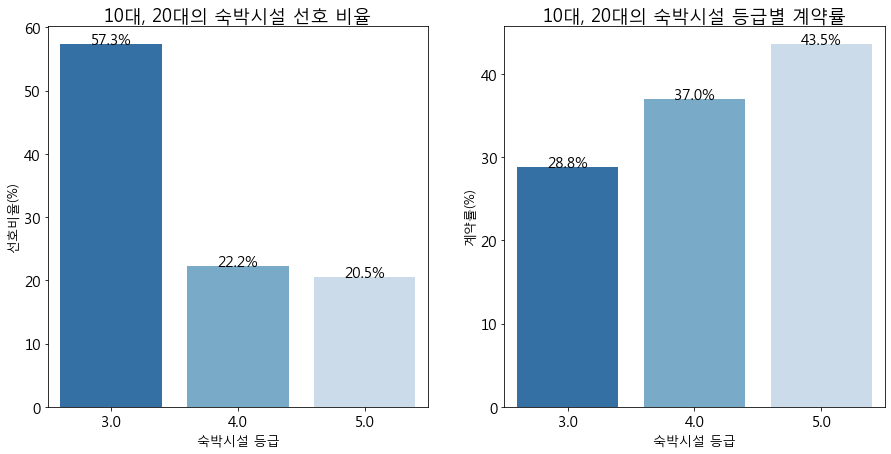

In [151]:
# 10대~20대의 숙박시설 선호

    
    
plt.figure(figsize=(15,7))   
area1 = plt.subplot(1,2,1)    
df = ((train.loc[train['Age_category'].isin([0,1,2]), 'PreferredPropertyStar'].value_counts(normalize=True)*100).reset_index())
ax1 = sns.barplot(data=df, x = 'index', y='PreferredPropertyStar', palette='Blues_r', ax=area1)
plt.title('10대, 20대의 숙박시설 선호 비율', fontsize=18)
plt.xlabel('숙박시설 등급', fontsize=13)
plt.ylabel('선호비율(%)', fontsize=13)
write_percent_2(ax1,1)




df_10대20대 = train[train['Age_category'].isin([0,1,2])]
cross = pd.crosstab( df_10대20대['ProdTaken'], df_10대20대['PreferredPropertyStar'])  
계약률_1020 = round((cross/cross.sum()).loc[1:1]*100,4).rename(index={1:'계약률(%)'})
계약률_1020 = 계약률_1020.T.reset_index()

area2 = plt.subplot(1,2,2)   
ax2 = sns.barplot(data=계약률_1020, x = 'PreferredPropertyStar', y='계약률(%)', palette='Blues_r', ax=area2)
plt.title('10대, 20대의 숙박시설 등급별 계약률', fontsize=18)
plt.xlabel('숙박시설 등급', fontsize=13)
plt.ylabel('계약률(%)', fontsize=13)
write_percent_2(ax2, 1)
plt.show()


# 10~20대 고객의 숙박 등급 선호도
# 3 star 숙박등급을 선호하는 고객들이 과반수 이상 (57.3%)
# 4 star 선호 비중 (22.2%), 5 star 선호 비중 (20.5%)

#### 문제점 : 
- 10~20대 고객 중 3 star 숙박등급을 선호하는 고객 비중이 과반이상 (57.3%)인데 반해, 고객들의 계약률이 상대적으로 낮다.(28.8%)

- 3 star 숙박등급을 선호하는 고객의 니즈를 충족시키지 못 하고 있는 것으로 예상된다. 

#### 제안 : 
- (기존에 3star 숙박 등급을 제공하는 여행 패키지가 있다면), 이 상품 자체에 문제가 있는 것으로 예상되며, 상품 자체를 개선할 필요가 있다.  

- (기존에 3star 숙박 등급을 제공하는 여행 패키지가 없다면), 고객의 니즈에 맞는 3 star 숙박 등급을 제공하며 가격을 낮춘 패키지 상품을 추가 개발할 필요성이 있다.


#### 고객 데이터 분석 결론 1
* 구매전환률이 높은 10~20대 그룹을 타겟으로 상품 개발, 타겟 광고 등을 진행하는 것을 제안하여 고객수를 늘리는 방안
-> 가장 구매전환률이 높은 그룹이기 때문에 이들을 공략하여 타겟 광고 및 특화 상품 개발이 필요 (Basic 상품을 가장 선호)
-> 현재 3star 숙박을 선호하는 고객들의 계약률이 떨어지는 상황으로, 니즈에 맞는 합리적 가격의 패키지 상품을 개발할 필요성이 있음



#### 2-4. 계약률이 낮은 30대 후반 고객층의 계약률을 높이기 위한 방안


In [129]:
# [MaritalStatus]
# Single, Unmarried, Divorced, Married로 나뉨 -> 미혼상태/기혼상태로 라벨인코딩


# Single/Unmarried/Divorced -> 미혼 
# Married -> 기혼


train['MaritalStatus_3'] = train['MaritalStatus'].replace({ 'Single':'Single/Unmarried/Divorced',
                                                           'Unmarried':'Single/Unmarried/Divorced',
                                                            'Divorced' : 'Single/Unmarried/Divorced'})
cross = pd.crosstab(train['MaritalStatus_3'],train['Age_category'])
cross.columns = ['10대','20~24세','25~29세','30~34세','35세~39세', '40~44세','45~49세', '50~54세','55세이상']

print('[나이대별 결혼상태(%)]')
cross.loc['합계'] = cross.sum()
round(cross/cross.loc['합계']*100,1).T

# 기혼과 미혼 상태 : 25세 이후부터는 약 1:1의 비율

[나이대별 결혼상태(%)]


MaritalStatus_3,Married,Single/Unmarried/Divorced,합계
10대,0.0,100.0,100.0
20~24세,29.2,70.8,100.0
25~29세,47.4,52.6,100.0
30~34세,47.4,52.6,100.0
35세~39세,51.6,48.4,100.0
40~44세,53.7,46.3,100.0
45~49세,52.0,48.0,100.0
50~54세,46.4,53.6,100.0
55세이상,47.9,52.1,100.0


[MaritalStatus에 따른 평균 계약률 (30대 후반 그룹 제외)]


MaritalStatus_3,Married,Single/Unmarried/Divorced
ProdTaken,,
계약률(%),15.0,27.0


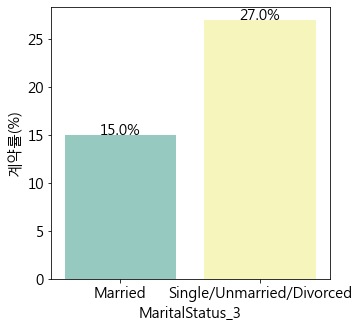

In [153]:
# [MaritalStatus에 따른 계약률(구매전환률)]

# MaritalStatus는 Single, Unmarried, Divorced, Married로 나뉨 -> 미혼상태/기혼상태로 라벨인코딩

# Single/Unmarried/Divorced -> 미혼 
# Married -> 기혼

삼십대후반제외 = train[train['Age_category'].isin([1,2,3,5,6,7])] # 30대 후반을 제외
cross = pd.crosstab( 삼십대후반제외['ProdTaken'], 삼십대후반제외['MaritalStatus_3'])  
print('[MaritalStatus에 따른 평균 계약률 (30대 후반 그룹 제외)]')
df_삼십대후반제외 = round((cross/cross.sum()).loc[1:1]*100,1).rename(index={1:'계약률(%)'})


# 30대 후반 그룹을 제외하면, 미혼 상태 그룹(Single/Unmarried/Divorced)이 기혼 상태 (Married) 그룹에 비해 계약률이 1.8배 정도 높게 나타난다.
plt.figure(figsize=(5,5))
df_삼십대후반제외2 = df_삼십대후반제외.T.reset_index()
ax = sns.barplot(data=df_삼십대후반제외2,  x='MaritalStatus_3', y='계약률(%)',palette='Set3')
write_percent_2(ax, 1)
df_삼십대후반제외

평균적으로 미혼 그룹의 계약률이 기혼 그룹의 약 1.8배 정도 높다

,20~24세,25~29세,30~34세,35세~39세,40~44세,45~49세,50~54세
결혼상태,,,,,,,
기혼,27.9,20.8,13.1,12.2,12.9,11.8,13.3
미혼,48.0,34.5,28.0,10.3,19.2,15.6,16.0


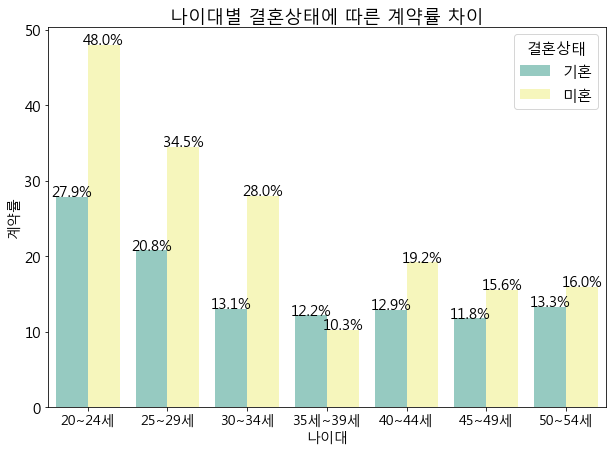

In [155]:
# [ 나이대별 MaritalStatus에 따른 계약률 차이 ]
data=pd.DataFrame()
for i in [1,2,3,4,5,6,7]:
             df = train.loc[train['Age_category']==i,:]
             cross = pd.crosstab(df['MaritalStatus_3'],df['ProdTaken'])
             a=round((cross.T/cross.sum(axis=1)).iloc[1]*100,1).rename(index={1:'계약률(%)'}).to_list()
             data[i]=a

data['결혼상태'] = ['기혼','미혼']
data.columns = ['20~24세','25~29세','30~34세','35세~39세', '40~44세','45~49세', '50~54세', '결혼상태']
df_계약률 = pd.melt(data, id_vars='결혼상태', var_name='나이대', value_name='계약률')
df_계약률
plt.figure(figsize=(10,7))
plt.xlabel('나이대',fontsize=14)
plt.ylabel('계약률(%)',fontsize=14)
plt.xticks(fontsize=14)
plt.title('나이대별 결혼상태에 따른 계약률 차이', fontsize=18)
ax = sns.barplot(data = df_계약률, x='나이대', y='계약률', hue='결혼상태', palette='Set3')
write_percent_2(ax, 1)
data.set_index('결혼상태')


#### 문제점 : 
* 30대 후반 그룹만 유독, 미혼 그룹의 계약률이 기혼 그룹보다 떨어지는 것을 확인할 수 있다.
  (평균적으로 미혼 그룹의 계약률이 기혼 그룹의 약 1.8배 정도 높다)
* 미혼, 기혼 그룹 계약률의 평균적인 경향성을 고려하였을 때, 30대 후반 미혼 그룹의 계약률을 끌어 올릴 수 있는 가능성이 있다고 생각한다.

#### 제안
* 추가 조사를 통해 30대 후반 미혼 그룹 계약률이 낮은 이유를 구체적으로 파악하여 해결 방안을 찾을 것을 제안한다.
(**이 데이터셋을 가지고는 구체적 원인 파악에 한계가 있음) 

#### 고객 데이터 분석 결론 2
* 방문 고객 수는 많지만 구매전환률이 낮은 30대 후반 고객층의 계약률을 높일 수 있는 인사이트 제안
-> 평균적으로 미혼 그룹의 계약률이 기혼 그룹의 약 1.8배 정도 높은데 비해, 유독, 30대 후반 미혼 고객의 구매전환률만 기혼 고객보다 낮은 것이 파악됐다. 
-> 30대 후반 미혼 그룹에만 나타나는 문제의 원인을 파악하여 해결하는 것을 제안


#### 3 영업 데이터 분석 및 비지니스 과제 도출   
#### 3-1    영업 관련 데이터 분석 

In [156]:
# TypeofContact 교차분석

# 카이제곱 독립성 검정 (범주형 혹은 명목형 변수 2개에 대한 개수 값이 필요함)

#h0 : 두 변수가 관련성이 없다.
#h1 : 두 변수가 관련성이 있다. 
    
# 두 변수 수준들의 각 조합에 대해 최소 5개의 기대값이 필요함
# 조합별 기대값이 5개 미만이면 검정 결과를 신뢰할 수 없음

import matplotlib.gridspec as gridspec
import scipy.stats as stats
from scipy.stats import chi2_contingency

In [157]:
# 서비스 관련 변수들로, 계약률이 어떻게 달라지는지 확인해본다. 

cols = [ 'TypeofContact', 'NumberOfFollowups', 'PitchSatisfactionScore','ProductPitched','DurationOfPitch(주별)']
li=[]

for x in cols :
    chi2, p, dof, expected_ = chi2_contingency( pd.crosstab(train[x],train['ProdTaken']))
    if p > 0.05:
        li.append(x)
    else :
        실제 = pd.crosstab(train[x],train['ProdTaken']).rename(columns = {0:'실제_0',1:'실제_1'})
        예상 = pd.DataFrame(expected_,columns=['예상_0','예상_1'])
        pd.concat([예상,실제], 1)
        expected_rate = round((예상['예상_1']/예상.sum(axis=1)).values[0]*100,1)
        print()
        print(round(실제['실제_1']/실제.sum(axis=1)*100,1))
        print(round(p,10))
print(f'pass : {li}')   





TypeofContact
Company Invited    22.7
Self Enquiry       17.9
dtype: float64
0.0003791808

NumberOfFollowups
1.0    13.2
2.0    10.2
3.0    16.8
4.0    19.0
5.0    24.9
6.0    39.5
dtype: float64
0.0

PitchSatisfactionScore
1    15.7
2    15.6
3    21.8
4    18.8
5    21.9
dtype: float64
0.0005044398

ProductPitched
Basic           30.0
Deluxe          11.6
King             8.7
Standard        16.1
Super Deluxe     7.6
dtype: float64
0.0

DurationOfPitch(주별)
0.0    13.5
1.0    16.9
2.0    19.8
3.0    22.3
4.0    28.4
5.0    17.2
dtype: float64
2.077e-07
pass : []


In [158]:
# 카이제곱 분석을 통해, 고객의 제품 인지 방법(Type of Contact)과 계약 여부(Prod Taken) 변수간의 관련성 파악

# Type of Contact : 고객의 제품 인지 방법 (회사의 홍보 or 스스로 검색)
# Prod Taken : 계약 여부 (계약 완료 or 미계약)

chi2, p, dof, expected_ = chi2_contingency( pd.crosstab(train['TypeofContact'],train['ProdTaken']))
print('chi2 statistic: ', chi2)
print('p value: ', p)

실제 = pd.crosstab(train['TypeofContact'],train['ProdTaken'])
실제.columns = [['실제','실제'],['미계약(건)','계약(건)']]
예상 = pd.DataFrame(expected_, index=['Company Invited','Self Enquiry'],columns=[['예상','예상'],['미계약(건)','계약(건)']]).applymap(lambda x : round(x))
실계약률 = pd.DataFrame(round(실제['실제','계약(건)']/실제.sum(axis=1),3)*100, columns=[['실제'],['계약률(%)']])
예상계약률 = pd.DataFrame(round(예상['예상','계약(건)']/예상.sum(axis=1),3)*100, columns=[['예상'],['계약률(%)']])

pd.concat([예상,예상계약률,실제,실계약률], 1)


chi2 statistic:  12.632090817468232
p value:  0.0003791808406656593


예상                  실제             
                미계약(건) 계약(건) 계약률(%) 미계약(건) 계약(건) 계약률(%)
Company Invited    976   233   19.3    934   275   22.7
Self Enquiry      2354   564   19.3   2396   522   17.9

* 카이제곱 분석 결과 p-value 가 0.05이하로, Type of Contact는 여행상품 신청에 영향을 미친다고 볼 수 있다.

* 고객이 스스로 검색하여 유입된 경우에 비해, 회사의 홍보/영업으로 유입된 고객의 여행상품 계약률이 약 5% 정도 높게 나타난다.


NumberOfFollowups,1.0,2.0,3.0,4.0,5.0,6.0
계약률(%),13.2,10.2,16.8,19.0,24.9,39.5


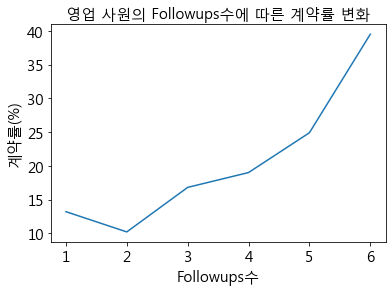

In [159]:
# 영업 사원의 Followups수에 따른 계약률 변화

cross = pd.crosstab(train['NumberOfFollowups'] , train['ProdTaken'])
계약률 = pd.DataFrame(round(cross[1]/cross.sum(axis=1),3)*100).rename(columns={0:'계약률(%)'})


plt.plot(pd.DataFrame(round(cross[1]/cross.sum(axis=1),3)*100))
plt.title('영업 사원의 Followups수에 따른 계약률 변화', fontsize=15)
plt.xlabel('Followups수')
plt.ylabel('계약률(%)')
계약률.T

   * 영업사원의 followup이 2회일 때 가장 계약률이 낮고, 3~6회까지 followup이 많아질 수록 계약률이 상승했다.
##### 고객이 2번째 followup 때 계약을 하지 않으면  신속히 다른 상품을 추천하는 등 추가 followup을 해야할 필요성이 있을 것으로 보인다.

<AxesSubplot:>

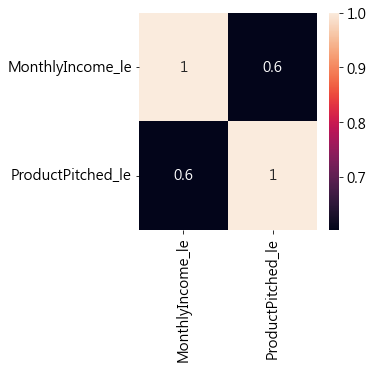

In [160]:
# [소득과 여행 추천 상품, 여행 상품 신청률과의 관계]

# 상품등급 라벨인코딩
 #'Basic'-> 1
 #'Standard'-> 2
 #'Deluxe'->3
 #'Super Deluxe'->4
 #'King'->5 
    
    
corr= train[['MonthlyIncome_le','ProductPitched_le']].corr()

plt.rcParams['figure.figsize'] = [4, 4]
sns.heatmap(corr, annot= True)

고객의 소득이 증가함에 따라 영업사원의 추천 상품 등급도 상향되는 상관관계를 갖는다. (상관계수: 0.6)


In [161]:
# [영업사원의 상품 추천 관련] 

df_ProdTaken = train[train['ProdTaken']==1]
df_ProdUntaken = train[train['ProdTaken']==0]

a = pd.pivot_table(df_ProdTaken, index=['MonthlyIncome_le'], values = ['ProductPitched_le','PitchSatisfactionScore'], aggfunc = [sum, len])
b = pd.pivot_table(df_ProdUntaken, index=['MonthlyIncome_le'], values = ['ProductPitched_le','PitchSatisfactionScore'], aggfunc = [sum, len])
df_추천만족도 = pd.concat( [a[('sum', 'ProductPitched_le')]/a[('len', 'ProductPitched_le')], a[('sum', 'PitchSatisfactionScore')]/a[('len', 'PitchSatisfactionScore')],
                        b[('sum', 'ProductPitched_le')]/b[('len', 'ProductPitched_le')],b[('sum', 'PitchSatisfactionScore')]/b[('len', 'PitchSatisfactionScore')]],1) 


df_추천만족도.columns =[['계약고객','계약고객','미계약고객','미계약고객'],['추천상품등급','추천만족도','추천상품등급','추천만족도']]
df_추천만족도



계약고객               미계약고객          
                    추천상품등급     추천만족도    추천상품등급     추천만족도
MonthlyIncome_le                                        
0                 1.100457  3.168950  1.153989  3.031540
1                 1.434932  3.119863  1.896254  2.987512
2                 2.305970  3.320896  2.656331  3.038760
3                 2.212121  3.181818  2.453368  2.898964
4                 2.405405  3.621622  2.604651  3.104651
5                 2.755102  3.285714  3.559809  3.181818

#### 소득과 여행 추천 상품, 여행 상품 신청률과의 관계

여행 상품을 신청한 계약 고객(ProdTaken=1)은     
여행 상품을 신청하지 않은 미계약 고객(ProdTaken=0)에 비해서        
영업 직원으로부터 추천받은 상품의 평균 등급(ProductPitched) 낮고,     
추천 만족도(PitchSatisfactionScore)는 높은 것을 확인할 수 있다.     

 
-> 영업사원에게 어떤 상품을 추천받는가가 고객 계약 여부에 영향을 미칠 수 있다.

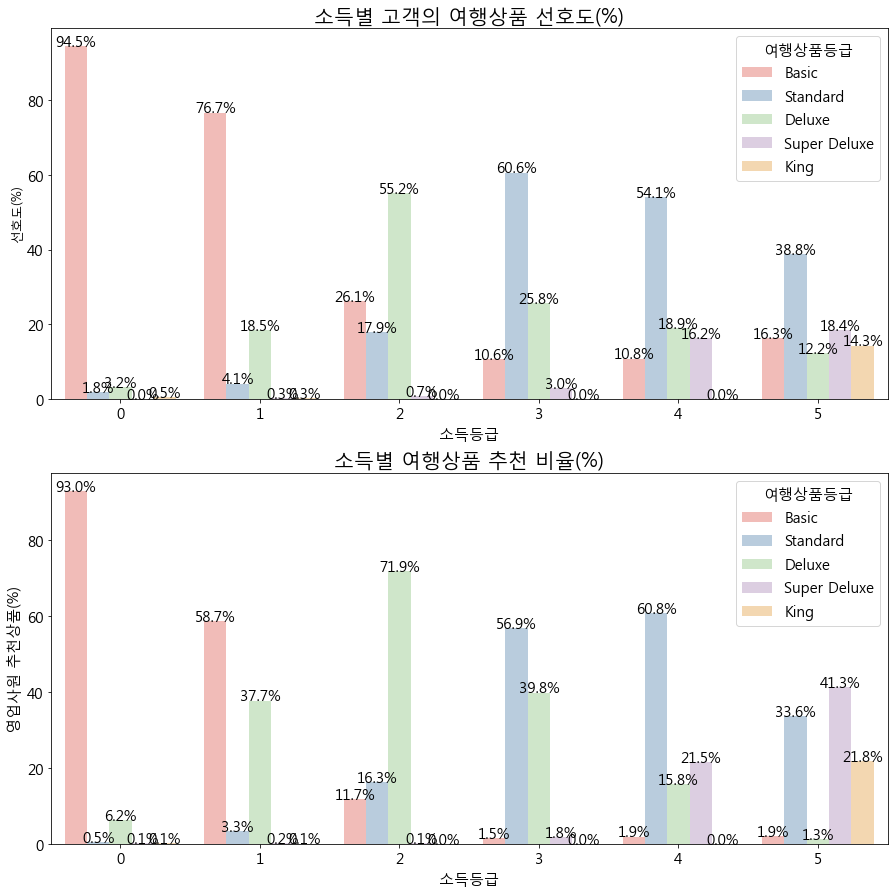

In [165]:
# 소득 구분별 선호도와 추천 상품 비율을 확인하기위한 시각화

plt.figure(figsize=(15,15))


# 고객 선호도 (%) 그래프 
a=[]
df= pd.DataFrame(index=['Basic','Standard','Deluxe','Super Deluxe','King']).reset_index().rename(columns={'index':'여행상품등급'})
for i in [0,1,2,3,4,5] :
    a = (df_ProdTaken.loc[df_ProdTaken['MonthlyIncome_le']==i,'ProductPitched'].value_counts(normalize=True)*100).reset_index()
    a.columns = ['여행상품등급',i]
    df= pd.merge(df,a,on='여행상품등급',how='left')

area1 = plt.subplot(2,1,1)
df2 = pd.melt(df, id_vars='여행상품등급', var_name='소득등급',value_name='선호도(%)')
df2 = df2.fillna(0)
ax1 = sns.barplot(data=df2, x='소득등급', y='선호도(%)', hue='여행상품등급', ax=area1, palette='Pastel1')
write_percent_2(ax1, 1)
plt.title('소득별 고객의 여행상품 선호도(%)', fontsize=20)
plt.ylabel('선호도(%)', fontsize=13)


# 영원사원 추천상품 (%) 그래프 
a=[]
df= pd.DataFrame(index=['Basic','Standard','Deluxe','Super Deluxe','King']).reset_index().rename(columns={'index':'여행상품등급'})
for i in [0,1,2,3,4,5] :
    a = (train.loc[train['MonthlyIncome_le']==i,'ProductPitched'].value_counts(normalize=True)*100).reset_index()
    a.columns = ['여행상품등급',i]
    df= pd.merge(df,a,on='여행상품등급',how='left')    
    
    
df2 = pd.melt(df, id_vars='여행상품등급', var_name='소득등급',value_name='영업사원 추천상품(%)')
df2 = df2.fillna(0)

area2 = plt.subplot(2,1,2)
ax2 = sns.barplot(data=df2, x='소득등급', y='영업사원 추천상품(%)', hue='여행상품등급', ax=area2, palette='Pastel1')
plt.title('소득별 여행상품 추천 비율(%)', fontsize=20)
write_percent_2(ax2, 1)



##### 소득대별로, 상품 선호도와 실제 고객이 추천받은 상품을 비교했을 때,     
##### 고객의 실제 선호보다 다소 높은 등급의 상품을 추천하는 경향이 보인다.
##### 

* 예시 | 소득 1분위 그룹   
     .
* 상품 등급이 낮은 상품은 상대적으로 추천 비율이 낮다.         
(베이직 상품 선호도는 76.7%, 베이직 상품 추천은 58.7%)   
.     
* 상품 등급이 높은 상품은 상대적으로 추천 비율이 높다.     
(디럭스 상품 선호도는 18.5%, 디럭스 상품 추천은 37.7%)

#### 3-2    비지니스 과제 도출    

#### 문제

* 현재 영업사원 추천 상품 등급과 고객 선호 등급이 일치하지 않는 경우가 있는 것으로 보인다.(추천 등급이 다소 높은 경향) 

#### 제안
* 수요 예측 알고리즘을 만들어 고객의 수요를 기반으로 추천할 수 있도록 해야한다.

#### 3-3 영업 시 활용 가능한 상품 예측 모델 개발

#### 3-3-1 데이터 준비

In [218]:
# 계약 고객(ProdTaken==1)의 데이터를 train data로 사용해, 예측 모델을 만든다. 
# 미계약 고객의 데이터를 test data로 사용하여, 미계약 고객에게 어떤 상품을 추천했어야 하는지 알아보도록 한다.
df_ProdTaken = train[train['ProdTaken']==1]
df_ProdUntaken = train[train['ProdTaken']==0]

X_train = df_ProdTaken.drop(['ProdTaken','ProductPitched_le', 'PitchSatisfactionScore', 'TypeofContact_le','DurationOfPitch','NumberOfFollowups','DurationOfPitch(주별)'],1) 
Y_train = df_ProdTaken['ProductPitched_le']

# 영업사원에 추천에 필요한 고객 상품 수요 예측이기 때문에 고객 관련 데이터만 남긴다.
test = df_ProdUntaken.drop(['ProdTaken','ProductPitched_le', 'PitchSatisfactionScore', 'TypeofContact_le','DurationOfPitch','NumberOfFollowups','DurationOfPitch(주별)'],1) 


In [219]:
# 라벨 인코딩 
from sklearn.preprocessing import LabelEncoder
for i in ['Occupation', 'MaritalStatus'] :
    le = LabelEncoder()
    X_train[i] = le.fit_transform(X_train[i])
    test[i] = le.transform(test[i])

In [168]:
# 나머지 필요없는 컬럼 및 문자 컬럼은 drop +  월 소득은 민감한 정보이기 때문에, 삭제하고 모델링을 해본다.

df_train = X_train.drop(['MonthlyIncome', 'Designation','MonthlyIncome_le', 'Age','TypeofContact', 'ProductPitched', 'MaritalStatus_3', 'Age_category_2', 'NumberOfTrips_le','계약여부'],1).reset_index(drop=True)
df_test = test.drop(['MonthlyIncome', 'Designation', 'MonthlyIncome_le', 'Age','TypeofContact', 'ProductPitched', 'MaritalStatus_3', 'Age_category_2','NumberOfTrips_le','계약여부'],1).reset_index(drop=True)
Y_train = Y_train.reset_index(drop=True)

#### 3-3-2 모델링

In [182]:
# 렌덤 포레스트 default상태로 모델 생성 결과 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error , f1_score, accuracy_score, mean_squared_error 


from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(df_train, Y_train, stratify=Y_train, random_state=1234)


# 평가 지표 NMAE
rfc = RandomForestClassifier(random_state=42)
model = rfc.fit(x_train, y_train)
pred = model.predict(x_valid)
result = f1_score(y_valid, pred, average='weighted')
print('튜닝 전 score')
print( f'f1_score: {round(result,3)}')
print( f'accuracy_score : {accuracy_score(y_valid, pred)}')

튜닝 전 score
f1_score: 0.994
accuracy_score : 0.995


In [172]:
from sklearn.metrics import mean_absolute_error, accuracy_score 
import optuna
import lightgbm as lgb

from optuna import Trial
from optuna.samplers import TPESampler
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import mean_absolute_error , f1_score, accuracy_score, mean_squared_error 


def objective(trial: Trial) -> float:
    k = 0    
    cv_f1_score = {} 
    cv_accuracy ={}
    kf = StratifiedKFold(n_splits = 5)
    kf_split  = kf.split(df_train, Y_train)    

    for train_idx ,valid_idx in kf_split:
        x_train = df_train.iloc[ train_idx ]
        y_train = Y_train.iloc[ train_idx ]

        x_valid = df_train.iloc[ valid_idx ]
        y_valid = Y_train.iloc[ valid_idx ]        
        k += 1 
        
        params_lgb = {
       "random_state" : trial.suggest_int("random_state", 42, 100),
       "n_jobs": trial.suggest_int("n_jobs", 50, 200),
      #  "objective": "multiclass",
      #  "metric": "multi_logloss",
        "max_depth": trial.suggest_int("max_depth", 5, 10),
      #  "num_leaves": trial.suggest_int("num_leaves", 2, 256),
      #  "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1),
      #  "subsample": trial.suggest_float("subsample", 0.3, 1.0),
      #  "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
      # "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 30)
        }
    
        rfc = RandomForestClassifier(**params_lgb)
        model = rfc.fit(x_train, y_train)
        pred = model.predict(x_valid)
        result1 = f1_score(y_valid, pred, average='weighted')
        cv_f1_score[k] = result1
        result2 = accuracy_score(y_valid, pred)
        cv_accuracy[k]=result2
    return (cv_f1_score[1] + cv_f1_score[2] + cv_f1_score[3] + cv_f1_score[4] + cv_f1_score[5] + 
            cv_accuracy[1] +cv_accuracy[2] +cv_accuracy[3] +cv_accuracy[4] +cv_accuracy[5])/10


sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="maximize",
    sampler=sampler
)

study.optimize(objective, n_trials=20)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)


[I 2023-02-13 05:03:30,954] A new study created in memory with name: lgbm_parameter_opt
[I 2023-02-13 05:03:32,892] Trial 0 finished with value: 0.9986437342232491 and parameters: {'random_state': 64, 'n_jobs': 193, 'max_depth': 9}. Best is trial 0 with value: 0.9986437342232491.
[I 2023-02-13 05:03:34,649] Trial 1 finished with value: 0.9789473305674472 and parameters: {'random_state': 77, 'n_jobs': 73, 'max_depth': 5}. Best is trial 0 with value: 0.9986437342232491.
[I 2023-02-13 05:03:36,495] Trial 2 finished with value: 1.0 and parameters: {'random_state': 45, 'n_jobs': 180, 'max_depth': 8}. Best is trial 2 with value: 1.0.
[I 2023-02-13 05:03:38,174] Trial 3 finished with value: 0.9986805555555556 and parameters: {'random_state': 83, 'n_jobs': 53, 'max_depth': 10}. Best is trial 2 with value: 1.0.
[I 2023-02-13 05:03:39,884] Trial 4 finished with value: 0.9947165800282377 and parameters: {'random_state': 91, 'n_jobs': 82, 'max_depth': 6}. Best is trial 2 with value: 1.0.
[I 2023-0

Best Score: 1.0
Best trial: {'random_state': 45, 'n_jobs': 180, 'max_depth': 8}


Optuna 튜닝 결과     
* Best Score: 1.0     
* Best trial: {'random_state': 45, 'n_jobs': 180, 'max_depth': 8}

In [175]:

from sklearn.metrics import mean_absolute_error , f1_score, accuracy_score, mean_squared_error 
kf = StratifiedKFold(n_splits = 5)
kf_split  = kf.split(df_train, Y_train) 
k = 0    
result=0
cv_accuracy={}  
cv_f1_score={}
for train_idx ,valid_idx in kf_split:
    x_train = df_train.iloc[ train_idx ]
    y_train = Y_train.iloc[ train_idx ]

    x_valid = df_train.iloc[ valid_idx ]
    y_valid = Y_train.iloc[ valid_idx ]        
    k += 1 
    
    rfc = RandomForestClassifier(random_state= 45, 
                                 n_jobs= 180, max_depth=8)
    model = rfc.fit(x_train, y_train)
    model.predict(x_valid)
    pred = model.predict(x_valid)
    result1 = f1_score(y_valid, pred, average='weighted')
    cv_f1_score[k] = result1
    result2 = accuracy_score(y_valid, pred)
    cv_accuracy[k] = result2
print('튜닝 적용 score')
print(f'f1_score:{round((cv_f1_score[1] + cv_f1_score[2] + cv_f1_score[3] + cv_f1_score[4] + cv_f1_score[5])/5,4)}')
print(f'accuracy_score:{round((cv_accuracy[1] + cv_accuracy[2] + cv_accuracy[3] + cv_accuracy[4] + cv_accuracy[5])/5,4)}')

튜닝 적용 score
f1_score:1.0
accuracy_score:1.0


In [179]:
f1_score

<function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>

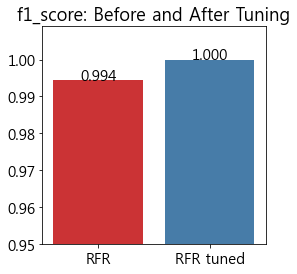

In [216]:
names = np.array(['RFR', 'RFR tuned'])
values= np.array([result, result1])

plt.figure(figsize=(4,4))
plt.title("f1_score: Before and After Tuning", fontsize=18)
plt.ylim(0.95, 1.009)
bar1 = sns.barplot(x = names, y = values, palette='Set1')

for p in bar1.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + p.get_height()*0.0001
    value = '{:.3f}'.format(p.get_height())
    plt.text(_x, _y, value, ha="center", fontsize=15) 

#### 3-3-3 최종 모델의 변수 중요도

<AxesSubplot:xlabel='변수중요도', ylabel='변수'>

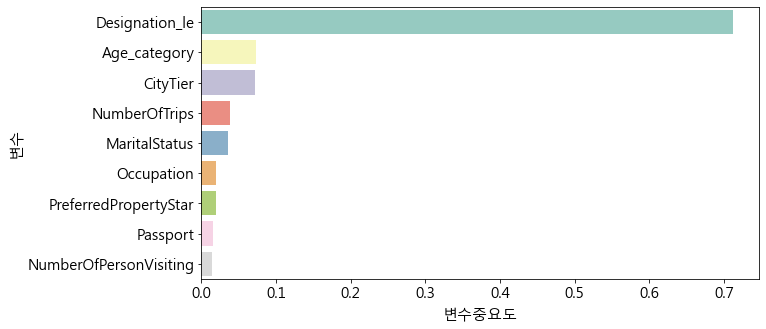

In [221]:
feature_importances = pd.DataFrame(model.feature_importances_, index=df_train.columns, columns=['변수중요도']).sort_values('변수중요도', ascending=False).reset_index().rename(columns={'index':'변수'})
plt.figure(figsize=(10,5))
sns.barplot(data=feature_importances, x='변수중요도', y='변수', orient='h', palette='Set3')

#### 영업 데이터 분석 결론 

* 영업사원의 followup이 2회일 때 가장 계약률이 낮고, 3회에서 6회까지 followup이 많아질 수록 계약률이 상승했다.      
-> 고객이 2번째 followup 때 계약을 하지 않으면 빠르게 다른 상품을 추천하거나 혹은 기존 상품의 장점을 한번 더 안내해드리도록 해야할 필요성이 있다.

    
* 영업사원에게 어떤 상품을 추천받는가가 계약 여부에 영향을 미칠 수 있으며,    
원하는 상품 등급보다 높은 등급의 상품을 추천받았을 때에 계약률이 감소할 수 있다는 가정을 세울 수 있다.    
-> 고객 데이터 기반 수요 예측 모델을 기반으로 상품 추천을 해야한다.     
-> RandomForest로 예측 모델 생성 완료  